# Signalklassifikation


In [1]:
# Import required libs
import os #allows for access to environment variables, is part of core 
import math
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting
import numpy as np # numerical arrays
import scipy as sp # scientific computing
import scipy.signal as sgn

### Einlesen der Daten

In [2]:
plt.rcParams["figure.figsize"] = (16,6)

# define data source
data_dir = '../input-data'
clip_air = np.load(os.path.join(data_dir,'ucddb013_air.npy'))
clip_SaO2 = np.load(os.path.join(data_dir,'ucddb013_SaO2.npy'))

**Q1a:** Schauen Sie sich die Daten über einen einfachen Plotbefehl an. Was fällt Ihnen auf? Wie nützlich sind diese Daten für Sie? Verwenden Sie hier und im Folgenden den Subplot-Befehl um beide Signale übereinender darzustellen.

< Tipp: Doppelklick mich! >
<!-- Da sie hier keine Metadaten erhalten, fehlt Ihnen natürlich sämtliche Information über die Messwerte.

 Was Sie hier sehen ist der Beginn einer Nacht für einen Aponoe/Hypopnoe-Patienten. Enthalten sind Messungen einer Nacht im Schlaflabor - einmal der Luftstrom an der Nase (indirekt - in mV), und einmal die Sauerstoffsättigung im Blut (in %).
 Die Samplingrate für beide Signale ist praktischerweise identisch bei 8 Hz. 

Den Originaldatensatz finden Sie übrigens hier: https://doi.org/10.13026/C26C7D 
Sie brauchen ihn jedoch nicht für diese Übung.-->

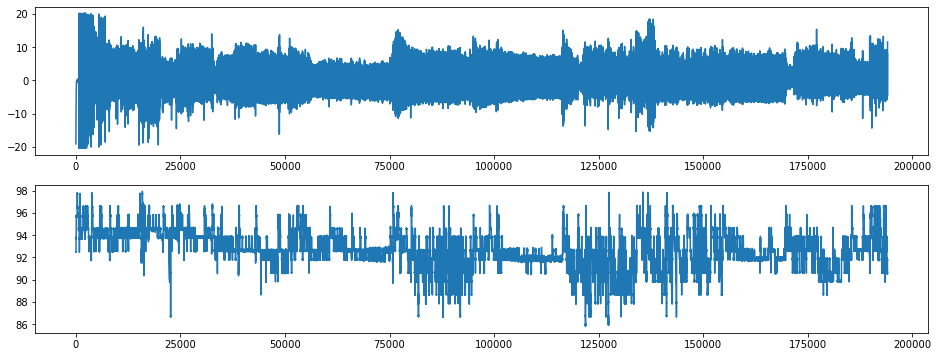

In [3]:
# subplot
plt.subplot(2,1,1)
plt.plot(clip_air)
plt.subplot(2,1,2)
plt.plot(clip_SaO2)

**Q1b:** Erweitern Sie ihren Plot durch sinnvolle Zeitangaben (und definieren Sie die Samplingfrequenz, welche Sie aus dem "Tipp" übernehmen können).

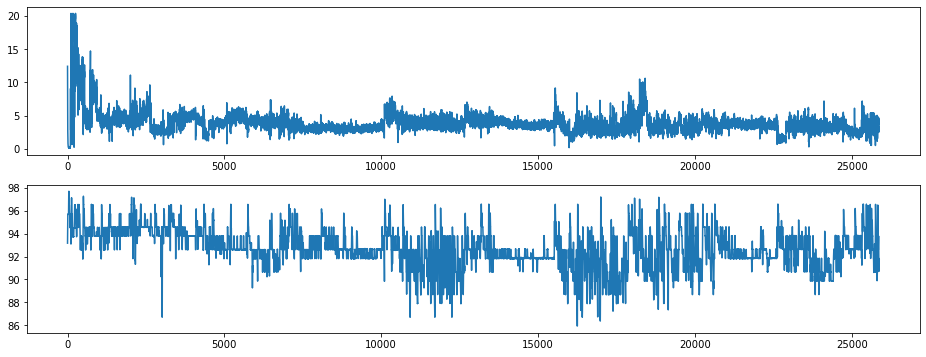

In [4]:
signal_fs_air = signal_fs_SaO2 = 1/8 # Kehrwert der Frequenz in Hertz ist Zeit zwischen zwei konsekutiven Samples in Sekunden

ma_width = 40
ma = np.ones(ma_width)/ma_width
# Da n
clip_air = np.convolve(abs(clip_air), ma)[ma_width:clip_air.size-ma_width]
clip_SaO2 = np.convolve(abs(clip_SaO2), ma)[ma_width:clip_SaO2.size-ma_width]

# Umrechnung in Minuten
samples_clip_air = np.arange(clip_air.size)/signal_fs_air/60
samples_clip_SaO2 = np.arange(clip_SaO2.size)/signal_fs_SaO2/60

plt.subplot(2,1,1)
plt.plot(samples_clip_air, clip_air)
plt.subplot(2,1,2)
plt.plot(samples_clip_SaO2, clip_SaO2)

### Klassifikation: Schlaf-Hypopnoe

Um Hypopnoen (also Minderatmung) nach der Definition der American Acedemy of Sleep Medicine (AASM) als solche zu klassifizieren, müssen folgende Vorraussetzungen erfüllt sein:
* Eine Abnahme des Luftstroms um >= 30% relativ zur Baseline (also der normalen Atmung der Person) über >= 10 s Länge
* Eine Abnahme der Sauerstoffsättigung um >= 3% relativ zur Baseline.

Die "normale Atmung" bezieht sich auf die Atmung im Schlafzustand.

Um die Tiefe der Atemzüge zu bestimmen berechnet man die Peak-to-Peak-Werte der Atmung, indem man die Differenz jeweils aufeinanderfolgender Maxima und Minima bestimmt. 
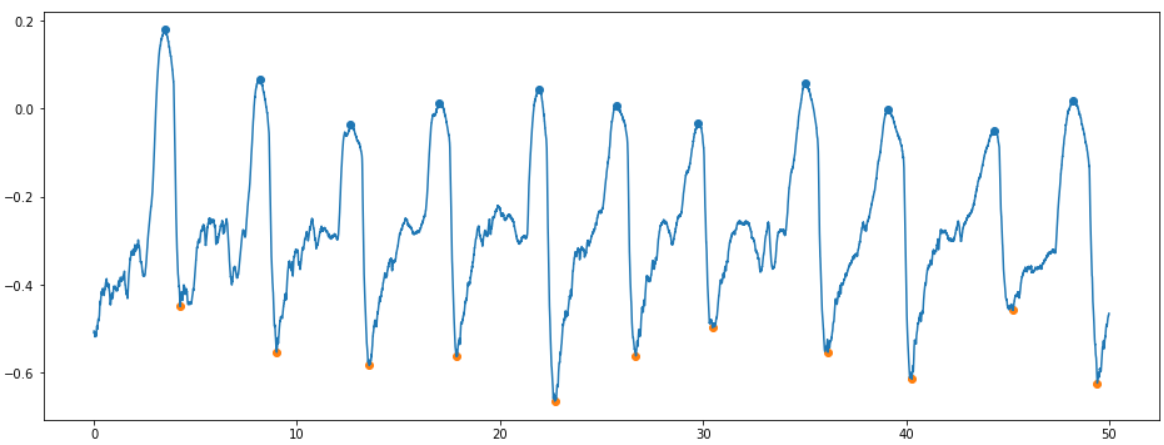

Bei einem Signal mit veränderlichen Eigenschaften ist es nicht ohne weiteres möglich, die richtigen Parameter zur Peak-Detektion zu finden (siehe [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)); die in der Literatur verwendeten Algorithmen sind deshalb vielfältig und nicht trivial.
Als vereinfachende Annahme im Sinne dieser Übung soll es deshalb ausreichen, wenn Sie das Atemsignal entsprechend modifizieren:

**Q2a:** Verwenden sie ein sliding-window, dessen Länge ungefähr der Periodenlänge 1 Atemzuges (optisch bestimmen) entspricht, und berechnen Sie jeweils in jedem Fenster den Peak-to-Peak-Wert (z.B. mit [np.ptp](https://numpy.org/doc/stable/reference/generated/numpy.ptp.html)). Dieses neue kontinuierliche Peak-to-Peak-Signal ist einfacher zu verarbeiten, als wenn sie korrekterweise diskrete Differenzen der echten Peaks (wie oben im Bild) bestimmen. Betrachten Sie dann Ausgangs- und ptp-Signal in einem Plot.

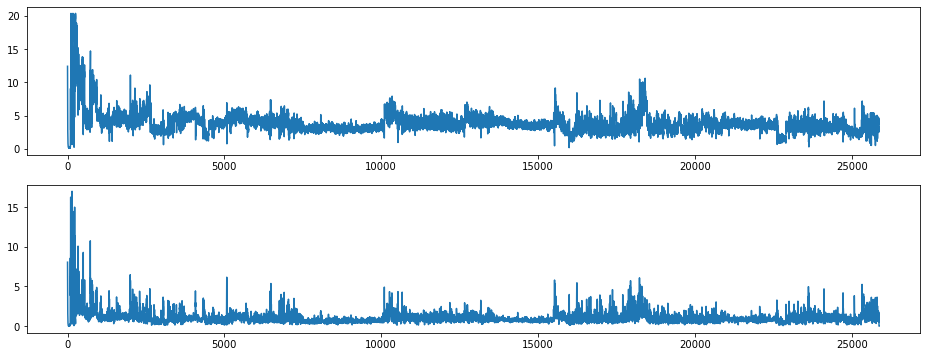

In [5]:
# Fensterlänge definieren
ptp_width = 40

def ptpSignal(sig, width) :
    ptp = np.zeros(sig.size)
    for i in range(sig.size - int(width)) :
        ptp[i] = np.ptp(sig[i:i+int(width)])
    return(ptp)

ptp_air = ptpSignal(clip_air, ptp_width)

# plot
plt.subplot(2,1,1)
plt.plot(samples_clip_air, clip_air)
plt.subplot(2,1,2)
plt.plot(samples_clip_air, ptp_air)

**Q2b:** Wählen Sie nun für die Bestimmung der Baselines (begründet) einen geeigneten Ausschnitt des Signals, den Sie als "normale Atmung" dieses Patienten annehmen. Glücklicherweise sind zu dem Signal Annotationen verfügbar, die Ihnen verraten, dass in den ersten 40 Minuten der Aufzeichnung unauffällig geschlafen wurde - verwenden Sie also diesen Abschnitt zur Bestimmung des Mittelwertes Ihres ptp-Signals und der Sauerstoffsättigung. Können Sie den gesamten Bereich so verwenden? Plotten Sie ihn vorsichtshalber vorher.

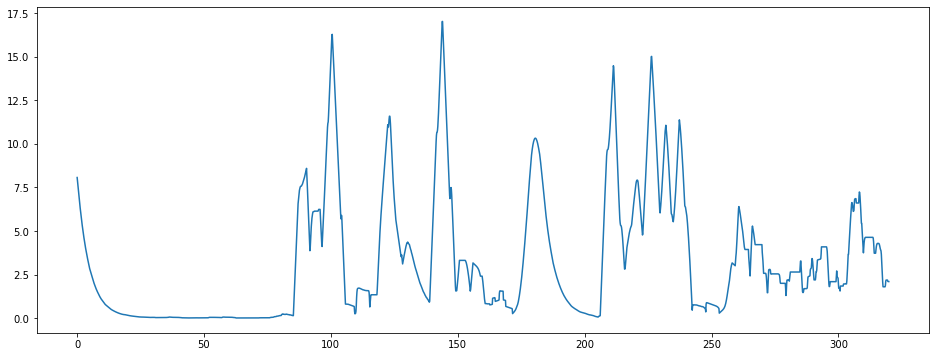

In [6]:
# Plot der ersten 40 Minuten
t40 = 40*60

plt.plot(samples_clip_air[0:t40], ptp_air[0:t40])

In [7]:
# Auswahl des Normbereiches
nber = range(100, t40)

# Bestimmen der Baseline-Werte
baseline_air = np.mean(ptp_air[nber])

baseline_SaO2 = np.mean(clip_SaO2)

**Q2c:** Überprüfen Sie ihr Ergebnis indem Sie die Sauerstoffsättigung und Ihre ermittelte Baseline dazu in einem Plot darstellen (z.B. mit [axhline](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.axhline.html)). Sie können auch recherchieren um die Plausibilität ihres Ergebnisses zu überprüfen.

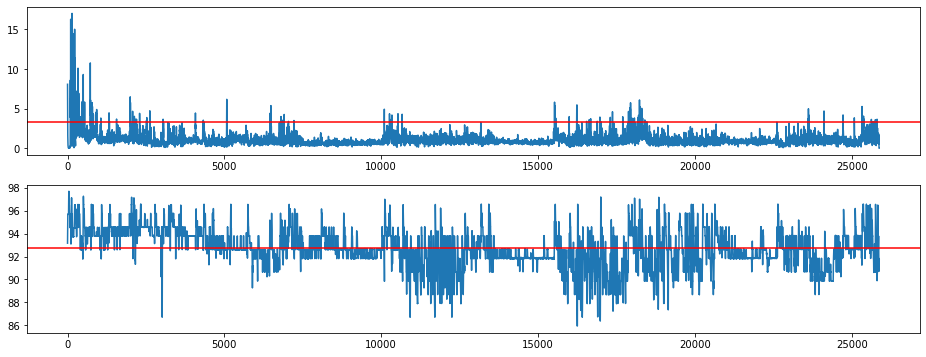

In [62]:
# Sauerstoffsättigung und Baseline plotten
plt.subplot(2,1,1)
plt.plot(samples_clip_air, ptp_air)
plt.axhline(baseline_air, color="r")
plt.subplot(2,1,2)
plt.plot(samples_clip_air, clip_SaO2)
plt.axhline(baseline_SaO2, color="r")

### Klassifikation der Hypopnoe-Episoden

Wir haben nun Baselines, anhand derer wir die in der Definition genannten Schwellwerte (als Abnahmen von der Baseline) umsetzen können. Weiter sieht die Definition jedoch eine Mindestdauer vor, ohne die nicht von Hypopnoe gesprochen werden darf.

**Q3a:** Erzeugen sie ein Array aus 1 und 0 der Länge des Signals (Sample), des für jeden Funktionswert des Ptp-Atmungs-Signals (mit 1) anzeigt, falls die Atmungs-Baseline um mehr als 30 % unterschritten wird. Tipp: Speichern die die Werte als Integer und nicht als logische Werte.

Schreiben Sie dann eine Funktion "get_episodes", die für ein solches Array und eine definierbare geforderte Mindestlänge eine Liste aus Start-Stopp-Tupeln derjenigen Indizes erzeugt, die die gewählten Mindestänge besitzen und wenden Sie diese Funktion auf Ihr Array an. Bestimmen Sie so potentielle Hypopnoe-Episoden von mindestens 10 Sekunden (Samplingrate!) Dauer.
Tipp: Betrachten Sie die 0/1 bzw. 1/0 Übergänge und denken Sie auch an den ersten u. letzten Wert.

In [9]:
# .astype(int) oder Multiplikation mit 1 zur Konversion in int-Array
air_classes = np.zeros(ptp_air.size)
air_classes[ptp_air<baseline_air*0.7] = 1

In [10]:
def get_episodes(arr, eps_minlen): # finde Episoden von Minderatmung mit ausreichender Länge
    # eps_list=[]
    arr_minlen = np.convolve(arr, np.ones(eps_minlen), 'same')
    arr_ind = np.zeros(arr.size)
    arr_ind[arr_minlen >= eps_minlen] = 1
    arr_startstop_ind = np.diff(arr_ind)
    arr_start_ind = np.where(arr_startstop_ind==1)[0]
    # print(arr_start_ind)
    arr_stop_ind = np.where(arr_startstop_ind==-1)[0]
    # print(arr_stop_ind)
    eps_list = list(map(list, np.transpose([arr_start_ind, arr_stop_ind])))
    return eps_list
    # return np.transpose([arr_start_ind, arr_stop_ind]) # Same as numpy

episodes = get_episodes(air_classes, math.ceil(10/signal_fs_air)) # 10 Sekunden hart kodiert

**Q3b:** Prüfen Sie nun für jeden Kandidaten in Ihrer Liste ob auch die 2. Bedingung (für mind. 1 Wert in der Episode) erfüllt ist und erzeugen Sie so eine Liste mit den "echten" Hypopnoe-Episoden.

In [48]:
# gleiches Vorgehen: Werte mit Sauerstoffgehalt unter Baseline finden
SaO2_classes = np.zeros(clip_SaO2.size)
SaO2_classes[clip_SaO2<baseline_SaO2*0.97] = 1
SaO2_ind = np.where(SaO2_classes==1)[0]

np_episodes = np.array(episodes)

In [30]:
def check_episodes(ind, epsarr):
    if ind >= epsarr[0] and ind <= epsarr[1]:
        cond = True
    else:
        cond = False
    return(cond)

In [53]:
hypopnea_classes = np.zeros(len(episodes))
# hypopnea_classes[SaO2_classes+air_classes >=2] = 1

for i in SaO2_ind:
    for j in range(len(episodes)):
        chk = check_episodes(i, episodes[j])
        if chk:
            hypopnea_classes[j]=1
    
combined_np_episodes=np_episodes[hypopnea_classes==1]

**Q3c:** Zu guter Letzt plotten Sie wieder in je einem Subplot (ptp-)Atmung und Sauerstoffsättigung. Sie können auch die Baselines oder die Schwellwerte mit axhlines einzeichnen lassen. Verwenden Sie dann z.B. [axvspan](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.axvspan.html) und zeichen Sie jeweils alle echten von Ihnen klassifizierten Hypopnoe-Episoden ein. 

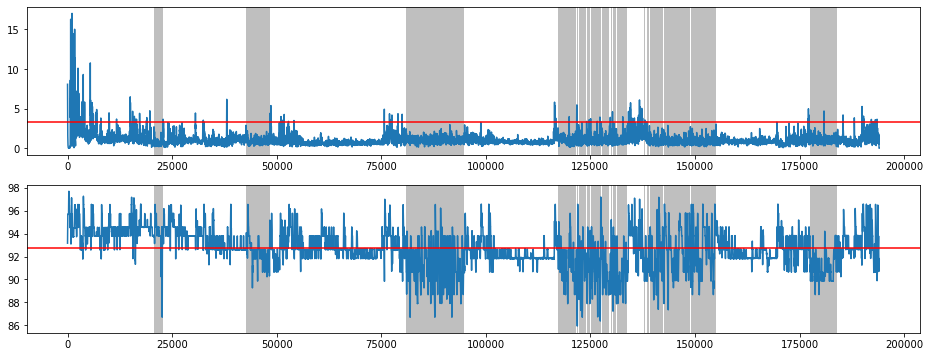

In [58]:
# erster Subplot: Peak-Air
plt.subplot(2,1,1)
plt.plot(ptp_air)
plt.axhline(baseline_air, color="r")

# Episoden hervorheben
for ce in combined_np_episodes :
    plt.axvspan(ce[0], ce[1], facecolor='0.5', alpha=0.5)

# zweiter Subplot: SaO2
plt.subplot(2,1,2)
plt.plot(clip_SaO2)
plt.axhline(baseline_SaO2, color="r")

# genau wie oben
for ce in combined_np_episodes :
    plt.axvspan(ce[0], ce[1], facecolor='0.5', alpha=0.5)